In [1]:
#GoogleDriveからマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#ライブラリインポート
import numpy as np
import cv2
import os


In [3]:
#データの読み込みとリサイズ
def load_and_resize_images(directory, img_height, img_width):
    images = []
    for filename in sorted(os.listdir(directory)):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (img_width, img_height))
            img_resized = img_resized[..., np.newaxis]
            images.append(img_resized)
    return images

img_height, img_width = 256, 256

# 各データセットのディレクトリパスを指定
train_image_dir = "/content/drive/MyDrive/dataset_1000/実験/train/images"
train_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/train/masks"

val_image_dir = "/content/drive/MyDrive/dataset_1000/実験/val/images"
val_mask_dir = "/content/drive/MyDrive/dataset_1000/実験/val/masks"

test_image_dir = "/content/drive/MyDrive/test/images"
test_mask_dir = "/content/drive/MyDrive/test/masks"

# 各データセットを読み込む
X_train = load_and_resize_images(train_image_dir, img_height, img_width)
y_train = load_and_resize_images(train_mask_dir, img_height, img_width)

X_val = load_and_resize_images(val_image_dir, img_height, img_width)
y_val = load_and_resize_images(val_mask_dir, img_height, img_width)

X_test = load_and_resize_images(test_image_dir, img_height, img_width)
y_test = load_and_resize_images(test_mask_dir, img_height, img_width)



In [4]:
# 画像とマスクの形状を変更

X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

X_test = np.array(X_test)
y_test = np.array(y_test)

In [5]:
#正規化
# 画像とマスクの形状を変更し、正規化を行う（これはそのままでOK）
X_train = np.array(X_train) / 255.0
y_train = np.array(y_train) / 255.0
X_val = np.array(X_val) / 255.0
y_val = np.array(y_val) / 255.0
X_test = np.array(X_test) / 255.0
y_test = np.array(y_test) / 255.0

In [6]:
import tensorflow as tf

# IoU関数の定義
def iou(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    iou = intersection / union
    return iou

# 精度を計算する関数
def precision(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred_f, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision

# 再現率を計算する関数
def recall(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f * y_pred_f, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true_f, 0, 1)))
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall

# F1スコアを計算する関数
def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

In [7]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/dataset_1000/model/fcn_1000_model.h5'

# 学習済みモデルのロード
model = load_model(model_path, custom_objects={'iou': iou, 'precision': precision, 'recall': recall, 'f1_score': f1_score})

In [8]:
def apply_gaussian_noise(images, noise_level=0.1):
    """
    画像のリストにガウスノイズを適用する関数。
    :param images: 画像のリスト。
    :param noise_level: ノイズの強度（標準偏差）。
    :return: ノイズが適用された画像のリスト。
    """
    noisy_images = []
    for img in images:
        gaussian_noise = np.random.normal(loc=0.0, scale=noise_level, size=img.shape)
        noisy_img = img + gaussian_noise
        noisy_img = np.clip(noisy_img, 0, 1)  # 画像の値を0から1の範囲に制限
        noisy_images.append(noisy_img)
    return np.array(noisy_images)

In [9]:
# テストデータにガウスノイズを適用
noise_level = 0.1  # ノイズの強度を設定
X_test_noisy = apply_gaussian_noise(X_test, noise_level=noise_level)

In [10]:
predictions = model.predict(X_test_noisy)

4/4 [==============================] - 7s 349ms/step


In [11]:
threshold = 0.5
predictions_t = (predictions > threshold).astype(np.uint8)


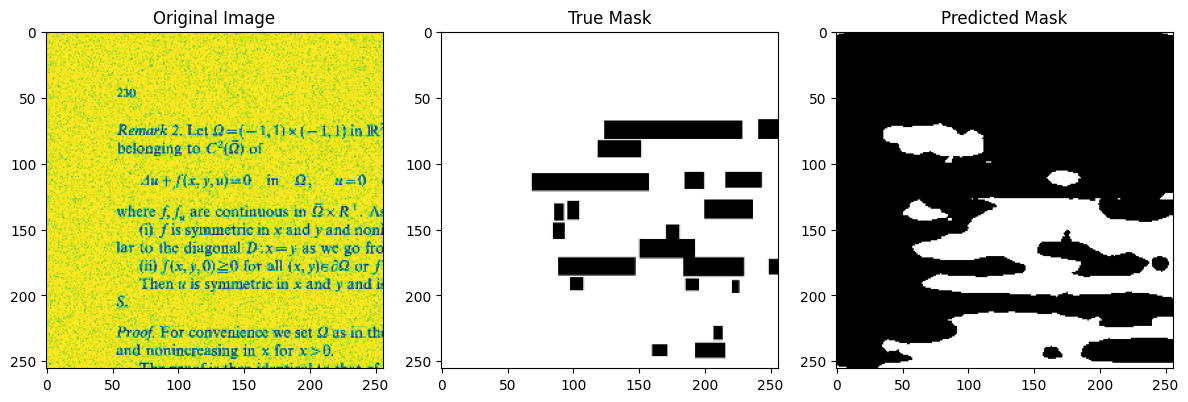

In [12]:
import matplotlib.pyplot as plt

idx = 0  # 表示する画像のインデックス

plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(X_test_noisy[idx])
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(y_test[idx].squeeze(), cmap='gray')
plt.title("True Mask")

plt.subplot(1, 3, 3)
plt.imshow(predictions_t[idx].squeeze(), cmap='gray')
plt.title("Predicted Mask")

plt.tight_layout()
plt.savefig('result.png')
plt.show()


1/1 [==============================] - 0s 22ms/step
Average IoU for the test set is: 0.2413


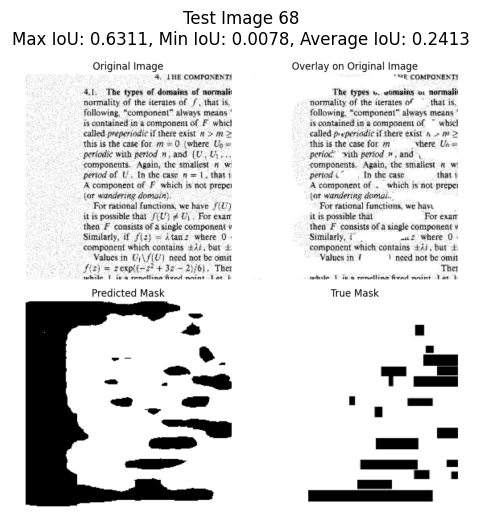

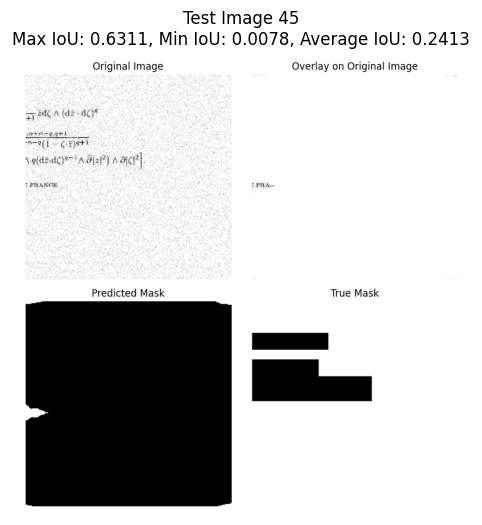

スコアは /content/drive/MyDrive/dataset_1000/ノイズ_result/FCN/FCN_ノイズ_scores.csv に保存されました。


In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import pandas as pd

def preprocess_image(image_array):
    image = Image.fromarray((image_array.squeeze() * 255).astype(np.uint8)).convert("L")  # グレースケールに変換
    image = image.resize((256, 256))
    image_array = np.asarray(image) / 255.0  # 0〜1の範囲に正規化
    image_array = image_array[..., np.newaxis]  # チャンネルの次元を追加
    image_array = image_array[np.newaxis, ...]  # バッチの次元を追加
    return image_array

# 保存先のディレクトリを作成
save_dir = '/content/drive/MyDrive/dataset_1000/ノイズ_result/FCN'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

ious = []
precisions = []
recalls = []
f1_scores = []

# 予測とIoU値の計算、画像の保存
for idx in range(len(X_test_noisy)):
    input_image = preprocess_image(X_test_noisy[idx])
    prediction = model.predict(input_image)
    predicted_mask = (prediction > threshold).astype(np.float32)
    true_mask = y_test[idx].squeeze()

    # IoUとDiceの値を計算してリストに追加
    iou_value = iou(tf.convert_to_tensor(true_mask, dtype=tf.float32), tf.convert_to_tensor(predicted_mask.squeeze(), dtype=tf.float32)).numpy()
    precision_value = precision(tf.convert_to_tensor(true_mask, dtype=tf.float32), tf.convert_to_tensor(predicted_mask.squeeze(), dtype=tf.float32)).numpy()
    recall_value = recall(tf.convert_to_tensor(true_mask, dtype=tf.float32), tf.convert_to_tensor(predicted_mask.squeeze(), dtype=tf.float32)).numpy()
    f1_score_value = f1_score(tf.convert_to_tensor(true_mask, dtype=tf.float32), tf.convert_to_tensor(predicted_mask.squeeze(), dtype=tf.float32)).numpy()

    ious.append(iou_value)
    precisions.append(precision_value)
    recalls.append(recall_value)
    f1_scores.append(f1_score_value)

    # オーバーレイ画像を作成
    overlay = np.where(predicted_mask.squeeze() == 0, 1, X_test_noisy[idx].squeeze())

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))

    axes[0, 0].imshow(X_test_noisy[idx].squeeze(), cmap='gray')
    axes[0, 0].set_title('Original Image')

    axes[1, 1].imshow(true_mask, cmap='gray')
    axes[1, 1].set_title('True Mask')

    axes[1, 0].imshow(predicted_mask.squeeze(), cmap='gray')
    axes[1, 0].set_title('Predicted Mask')

    axes[0, 1].imshow(overlay, cmap='gray')
    axes[0, 1].set_title('Overlay on Original Image')



    # 各サブプロットの軸を非表示にする
    for ax in axes.flatten():
        ax.axis('off')

    plt.tight_layout()
    # 1枚の画像ファイルとして保存
    plt.savefig(f'{save_dir}/test_image_{idx}.png')
    plt.close(fig)  # メモリ節約のためにクローズする

# IoU値が最大および最小のインデックスを見つける
max_iou_idx = np.argmax(ious)
min_iou_idx = np.argmin(ious)

# IoU値の平均を計算
average_iou = np.mean(ious)
print(f'Average IoU for the test set is: {average_iou:.4f}')

# オプショナル: 最大と最小のIoUの予測結果と平均IoUを表示
for idx in [max_iou_idx, min_iou_idx]:
    fig, ax = plt.subplots(figsize=(12, 6))
    img = plt.imread(f'{save_dir}/test_image_{idx}.png')
    ax.imshow(img)
    ax.axis('off')
    plt.title(f'Test Image {idx}\nMax IoU: {ious[max_iou_idx]:.4f}, Min IoU: {ious[min_iou_idx]:.4f}, Average IoU: {average_iou:.4f}')
    plt.show()

# IoUスコアのリストをDataFrameに変換
scores_df = pd.DataFrame({
    'iou': ious,
    'precision': precisions,
    'recall': recalls,
    'f1_score': f1_scores
})



# CSVファイルに保存
scores_csv_path = os.path.join(save_dir, 'FCN_ノイズ_scores.csv')
scores_df.to_csv(scores_csv_path, index=False)

print(f'スコアは {scores_csv_path} に保存されました。')
